In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_8mwkc7nt.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


## Model definition

In the previous example we assume constant thickness to be able to reduce the problem to one dimension. This keeps the probabilistic model fairly simple since we do not need to deel with complex geometric structures. Unfortunaly, geology is all about dealing with complex three dimensional structures. In the moment data spread across the physical space, the probabilistic model will have to expand to relate data from different locations. In other words, the model will need to include either interpolations, regressions or some other sort of spatial functions. In this paper, we use an advance universal co-kriging interpolator. Further implications of using this method will be discuss below but for this lets treat is a simple spatial interpolation in order to keep the focus on the constraction of the probabilistic model.

In [2]:
geo_model = gp.create_model('2-layers')
gp.init_data(geo_model, extent=[0, 10, 0, 10, 0, 10], resolution=[500,1,500])

Active grids: ['regular']


2-layers  2019-10-15 10:46

In [3]:
geo_model.add_surfaces('surface 1')
geo_model.add_surfaces('surface 2')
geo_model.add_surfaces('basement')
dz = geo_model.grid.regular_grid.dz
geo_model.surfaces.add_surfaces_values([dz, 0, 0], ['dz'])

,surface,series,order_surfaces,isBasement,color,id,dz
0,surface 1,Default series,1,False,#015482,1,0.02
1,surface 2,Default series,2,False,#9f0052,2,0
2,basement,Default series,3,True,#ffbe00,3,0


In [4]:
geo_model.add_surface_points(3, 5, 3, 'surface 1')
geo_model.add_surface_points(7, 5, 2, 'surface 1')

geo_model.add_surface_points(3, 5, 6, 'surface 2')
geo_model.add_surface_points(7, 5, 5, 'surface 2')

geo_model.add_orientations(5, 5, 100, 'surface 1', [0,0,1])

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,5.0,5.0,100.0,0.5001,0.5001,0.7501,0.0,0.0,1.0,0.0,0.0,1.0,surface 1,Default series,1,1,0.01


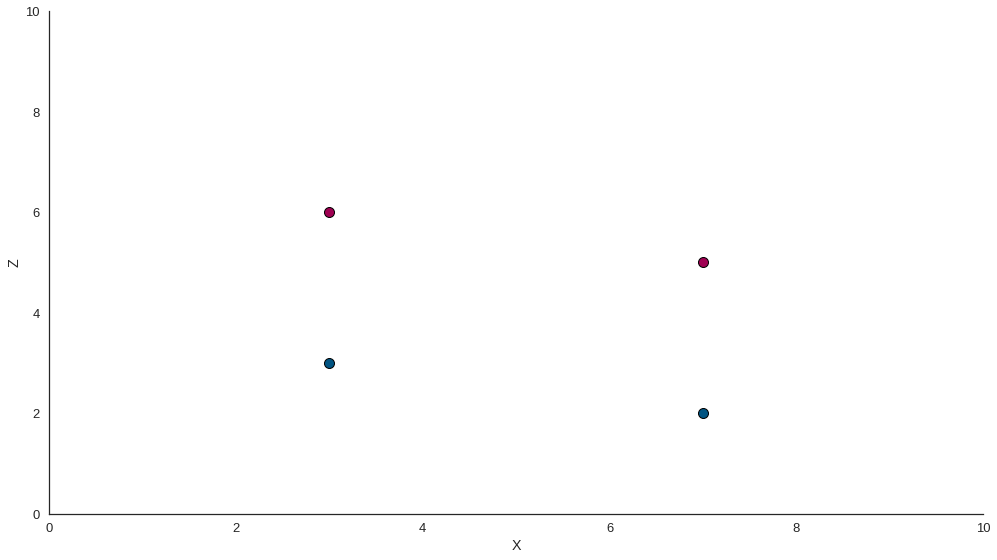

In [5]:
gp.plot.plot_data(geo_model)

In [6]:
gp.set_interpolation_data(geo_model, theano_optimizer='fast_run', gradient=True)

Compiling theano function...
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  0
Compilation Done!


In [7]:
geo_model.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,3.0,5.0,3.0,0.489896,0.5001,0.255202,surface 1,Default series,1.0,1.0,1.000000e-08
1,7.0,5.0,2.0,0.510304,0.5001,0.250100,surface 1,Default series,1.0,1.0,1.000000e-08
2,3.0,5.0,6.0,0.489896,0.5001,0.270508,surface 2,Default series,2.0,1.0,1.000000e-08
3,7.0,5.0,5.0,0.510304,0.5001,0.265406,surface 2,Default series,2.0,1.0,1.000000e-08


In [8]:
geo_model.interpolator.theano_graph.sig_slope.set_value(150)

In [9]:
gp.compute_model(geo_model, compute_mesh=False)


Lithology ids 
  [2.993937  2.9937415 2.9935396 ... 0.9995885 0.999575  0.9995623] 

In [10]:
from gempy.bayesian.plot_posterior import default_blue

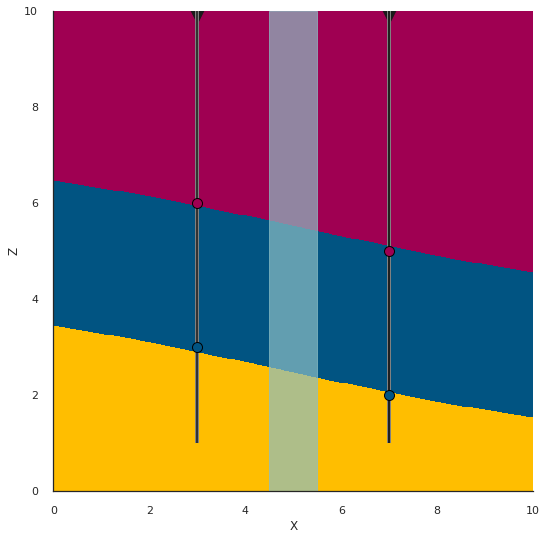

In [11]:
p = gp.plot.plot_section(geo_model, 0, show_data=True, direction='y')
p.fig.axes[-1].scatter([3], [9.9],  marker='v', s =200, c='k')
p.fig.axes[-1].scatter([7], [9.9],  marker='v', s =200, c='k')
p.fig.axes[-1].vlines(3, 1, 10, linewidth=4, color='gray', )
p.fig.axes[-1].vlines(7, 1, 10, linewidth=4, color='gray')
p.fig.axes[-1].vlines(3, 1, 10)
p.fig.axes[-1].vlines(7, 1, 10)
p.fig.axes[-1].vlines(7, 1, 10)
p.fig.axes[-1].fill_between(x=[4.5,5.5], y1=[0,0], y2=[10,10], alpha=.7, color=default_blue)

### Setting gempy into a pymc function


In [13]:
# Test gradient
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_loop,
                                [theano.grad(geo_model.interpolator.theano_graph.compute_series()[0][1][0:250000].sum(),
                                             geo_model.interpolator.theano_graph.input_parameters_loop[4])], inline=True,
                                 on_unused_input='ignore',
                                 name='geo_model')

In [12]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_loop,
                                [geo_model.interpolator.theano_graph.compute_series()[0][1][0:250000]], inline=True,
                                 on_unused_input='ignore',
                                 name='geo_model')

In [13]:
# We convert a python variable to theano.shared
input_sh = []
i = geo_model.interpolator.get_python_input_block()
for ii in i:
    input_sh.append(theano.shared(ii))

# We get the rescaling parameters:
rf = geo_model.rescaling.df.loc['values', 'rescaling factor']
centers = geo_model.rescaling.df.loc['values', 'centers']

# We create pandas groups by id to be able to modify several points at the same time:
g = geo_model.surface_points.df.groupby('id')
l = theano.shared(np.array([], dtype='float32'))

In [14]:
## theano.config.compute_test_value = 'ignore'

with pm.Model() as model:
    depths = pm.Normal('depths', geo_model.surface_points.df['Z'], np.array([4,4,4,4]), shape=4)
    depths_r = (depths - centers[2])/rf + 0.5001
    input_sh[4] =  tt.set_subtensor(input_sh[4][:, 2], depths_r)
    geo = geo_model_T(*input_sh)
    well = geo.reshape((500,1,500))[250, 0 ,:]
    thickness = pm.Deterministic('thickness', well.sum())
 #   sigma = pm.Gamma('$\sigma$', 1, .7)
 #   sigma = pm.Deterministic('$\sigma$', theano.shared(np.array([5]*4)))
    sigma = pm.Normal('$\sigma$', 5, 1)
    obs_thick = pm.Normal('y', mu=thickness, sd=5, observed=[2,1,2.5,2.1])



In [29]:
with model:
    trace = pm.sample(100, chains=1, tune=20, discard_tuned_samples=False,
                  compute_convergence_checks=False)
    prior = pm.sample_prior_predictive(1000)
    post = pm.sample_posterior_predictive(trace)


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [$\sigma$, depths]
100%|██████████| 120/120 [00:50<00:00,  2.52it/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 120/120 [00:00<00:00, 162.22it/s]


In [30]:
import arviz as az

data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)
data.posterior

<xarray.Dataset>
Dimensions:       (chain: 1, depths_dim_0: 4, draw: 120)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * depths_dim_0  (depths_dim_0) int64 0 1 2 3
Data variables:
    depths        (chain, draw, depths_dim_0) float32 5.8080444 ... 2.6865957
    $\sigma$      (chain, draw) float32 5.7306643 4.5703216 ... 3.6998963
    thickness     (chain, draw) float32 1.4903448 0.40508506 ... 1.0797414
Attributes:
    created_at:                 2019-10-08T09:04:57.393950
    inference_library:          pymc3
    inference_library_version:  3.7

In [31]:
data.prior['foo2'] = data.prior['depths'][0 ,:, 0]
data.prior['foo3'] = data.prior['depths'][0 ,:, 1]

In [32]:
data.posterior['foo2'] =  data.posterior['depths'][0 ,:, 0]
data.posterior['foo3'] =  data.posterior['depths'][0 ,:, 1]
data.posterior['foo4'] =  data.posterior['depths'][0 ,:, 2]
data.posterior['foo5'] =  data.posterior['depths'][0 ,:, 3]

In [33]:
data.posterior['like_std2'] = np.array([5]*200)

In [34]:
data.posterior['thickness']

<xarray.DataArray 'thickness' (chain: 1, draw: 120)>
array([[ 1.490345e+00,  4.050851e-01,  1.142663e+00,  1.339101e+00,
        -1.344798e-01,  7.447264e-02, -5.499653e-02,  1.744788e+00,
         1.338962e+00,  6.032530e+00, -4.191197e-02, -4.110571e-04,
         3.242863e-01,  5.494378e-01, -3.042207e-02,  4.509842e+00,
         4.509842e+00,  3.329153e+00,  3.507324e-01, -2.631593e-01,
        -1.409930e-01,  3.909242e-01, -1.539970e-01, -1.603192e+00,
         1.477919e+00,  4.691807e-01,  1.114734e-01, -2.117224e-01,
         3.422013e-01,  8.622035e-01,  1.725449e+00,  1.087425e+00,
        -4.987397e-01,  1.004313e+00,  2.394100e+00, -2.001129e-01,
         3.864429e+00, -3.298056e-01, -2.845508e-01, -7.784191e-02,
        -2.775294e-01, -6.241928e-02,  1.280942e+00,  3.822511e-03,
         2.840251e-02,  3.050534e-01,  2.265561e-01,  2.093997e-01,
         4.921347e+00,  2.940685e+00, -5.272036e-01,  4.445420e+00,
         3.265693e-01,  4.026714e-01,  3.524688e+00,  4.810091e

<IPython.core.display.Javascript object>


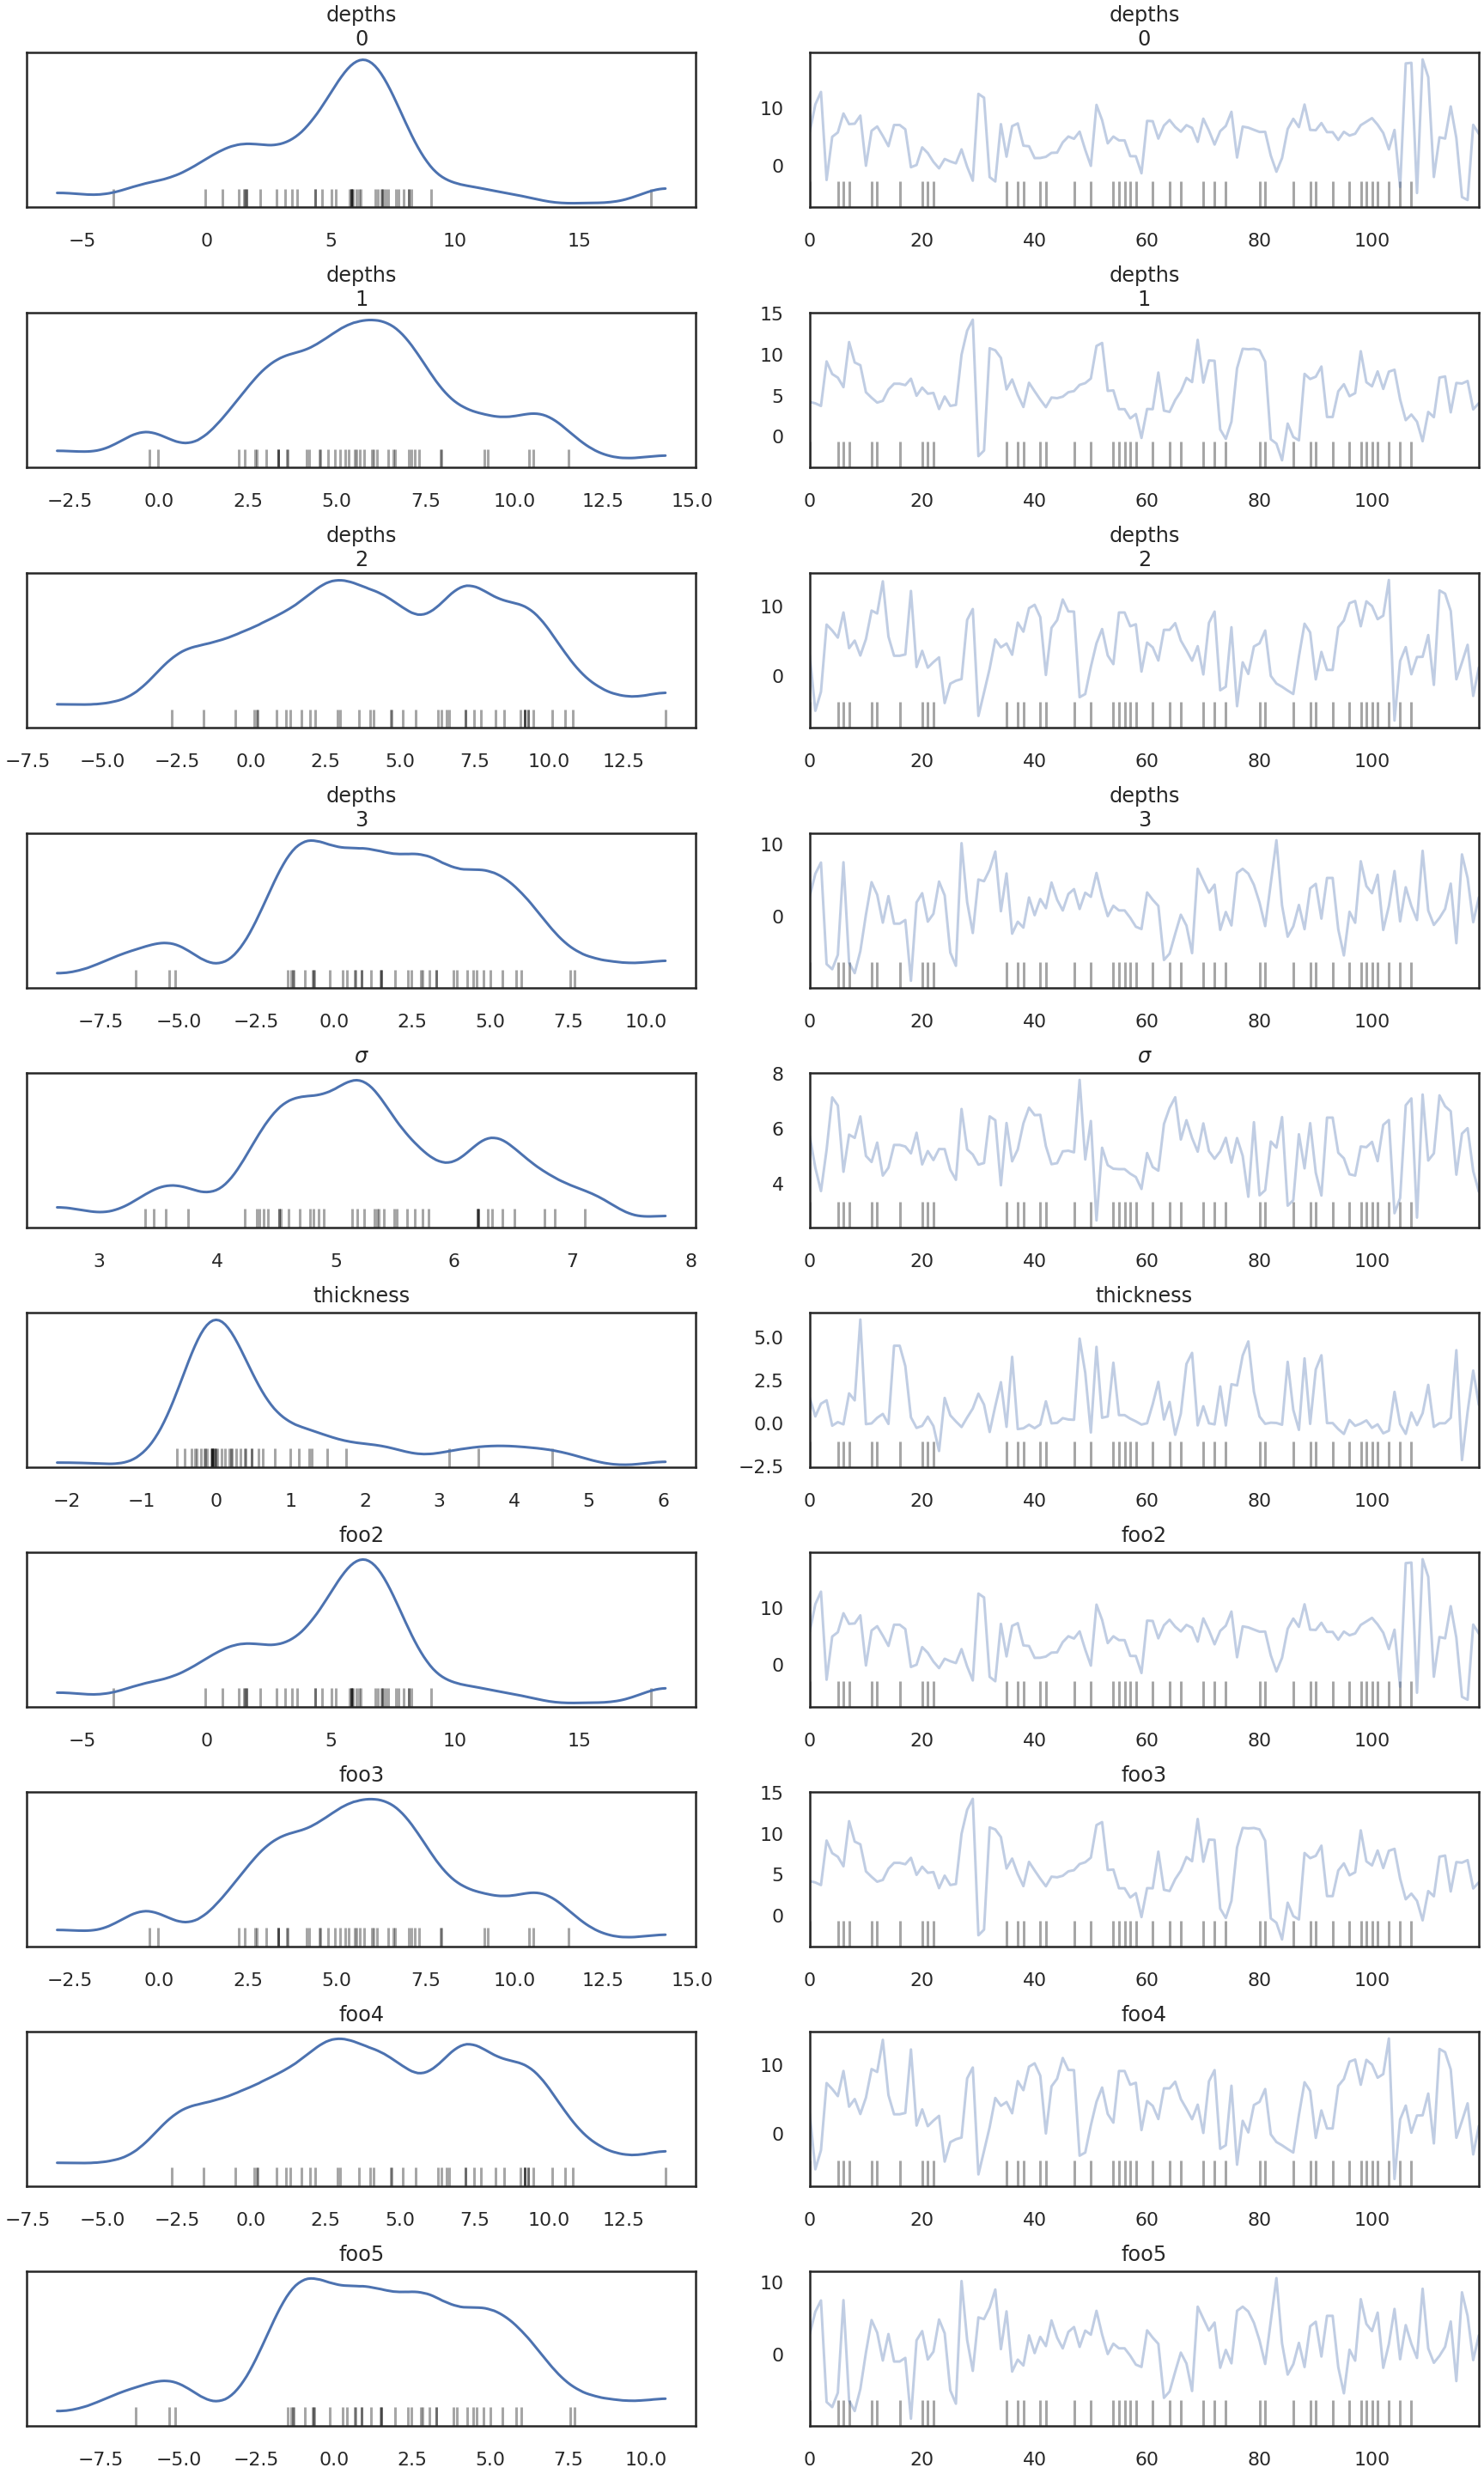

In [43]:
az.plot_trace(data);

<IPython.core.display.Javascript object>


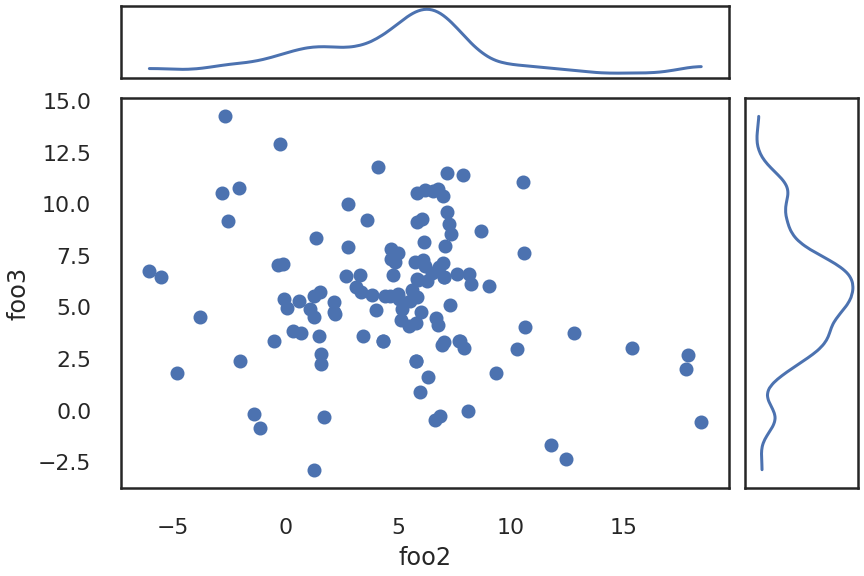

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5f6762bcc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5f675dac88>)

In [44]:
az.plot_joint(data, var_names=['foo2', 'foo3'])

In [45]:
# !git pull
from gempy.bayesian import plot_posterior as pp

import seaborn as sns


<IPython.core.display.Javascript object>


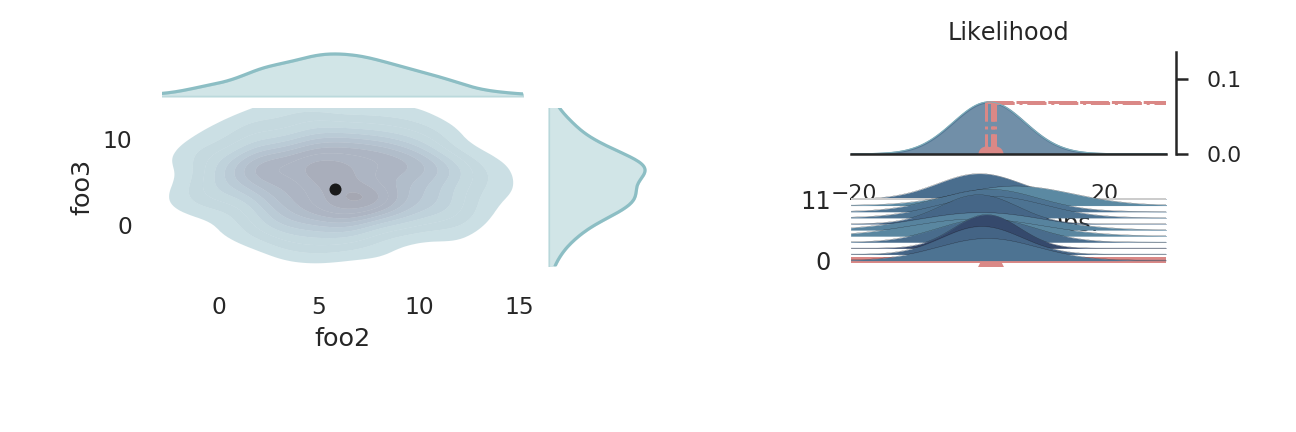

In [46]:
%matplotlib notebook
from importlib import reload
reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=True)

In [47]:
def change_iteration(iteration):
    p.plot_posterior(['foo2', 'foo3'], ['thickness', '$\sigma$'], 'y', iteration)
    # p.plot_posterior(['$\mu$', '$\sigma$'], ['$\mu$', '$\sigma$'], 'y', iteration)

In [48]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(change_iteration, iteration=(0, 200, 1))

interactive(children=(IntSlider(value=100, description='iteration', max=200), Output()), _dom_classes=('widget…

<function __main__.change_iteration(iteration)>

In [41]:
from gempy.bayesian.plot_posterior import my_cmap_full

<IPython.core.display.Javascript object>


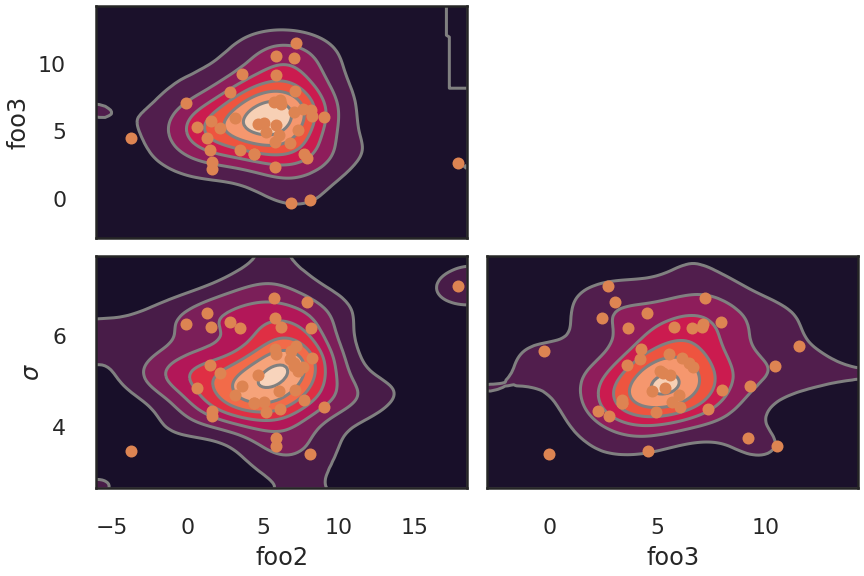

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff0894dd8>,
      dtype=object)

In [42]:
az.plot_pair(data, divergences=True, var_names=['foo2', 'foo3', '$\sigma$'], kind='kde', contour=True,
            colorbar=True)
             #plot_kwargs={'cmap':my_cmap_full});